In [163]:
import tensorflow as tf
# from tensorflow import keras
import nltk
import simplemma
import pandas as pd
import pathlib
import json
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [164]:
working_dir = pathlib.Path.cwd()

vocab_size = 10000
embedding_dim = 16
max_input_length = 25 # default
trunc_type='post'
padding_type='post'
oov_token = None # "<OOV>"
training_percent = 80
num_epochs = 25

In [165]:
clean_annotations = pd.read_csv(working_dir.parent / "data" / "output" / "clean_annotations.csv")

sentences = clean_annotations["relevant_text"].to_list()

# 1. Emergency
# 2. Normal
# 3. Non Emergency [Doctor]
# 4. Non Emergency [No Doctor]
labels = clean_annotations["classifications"].to_list()

In [166]:
def find_and_replace_in_string(input_string, replacements):
    for key, value in replacements.items():
        input_string = input_string.replace(key, value)
    return input_string


def find_longest_sentence_length(sentences):
    longest_length = max(len(sentence.split()) for sentence in sentences)
    return longest_length


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_" + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, "val_" + string])
    plt.show()


def sentence_cleaning_pipeline(sentences):
    """ 
    1. Remove punctuation
    2. Only lower letters
    3. Lemmatize
    4. Remove stop words
    5. Manual corrections
    """
    # tokenizer without punctuation
    regexp_tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+")

    # get Turkish stopwords
    nltk.download("stopwords")
    turkish_stopwords = nltk.corpus.stopwords.words("turkish")

    # word corrections
    with open(working_dir.parent / "data" / "input" / "word_corrections.json", "r") as file:
        word_corrections = json.load(file)

    return [
        find_and_replace_in_string(
            " ".join(
                [
                    simplemma.lemmatize(word, lang="tr").lower()
                    for word in regexp_tokenizer.tokenize(sentence)
                    if word not in turkish_stopwords
                ]
            ),
            word_corrections,
        )
        for sentence in sentences
    ]

def calculate_matching_ratio(list1, list2):
    if len(list1) != len(list2):
        return "Lists are not of the same length"
    matches = sum(i == j for i, j in zip(list1, list2))
    return matches / len(list1)

In [167]:
sentences[:5]

['Kontrastsız Beyin BT Kafa kaidesi ve kalvarial kemik yapılar normal sınırlardadır. 4.ventrikül ve bazal sisternalar normal genişliktedir. Posterior fossa oluşumları olağandır. İntrakranial hipo veya hiperdens sınırlanabilen patoloji saptanmadı. 3.ventrikül orta hatta ve normal genişliktedir. Lateral ventriküller olağandır. Beyin orta hat yapılarında yer değiştirme saptanmamıştır. Serebral sulkuslar olağandır. Nazal septum sola deviye görünümdedir ve BTye yansıyan tipik bir akut iskemi bulgusu mevcut değildir.  Ancak bu konuda klinik kuşku varsa olgunun diffüzyon MRG ile değerlendirilmesi ve detaylandırılması daha yararlı olacaktır. ',
 'Sol serebellar hemisferde sekel ??? ensefalomalazi sahaları ve eski iskemi sekeli değişiklikler izlenmektedir. Sağ serebellar hemisfer düzeyinde de benzer bulgular izlenmekle birlikte her iki serebellumda atrofi bulguları ve folyolarda belirginleşme mevcuttur. Supratentorial kesitlerin değerlendirilmesinde 3. ve lateral ventrikul, konveksite sulkuslar

In [168]:
clean_sentences = sentence_cleaning_pipeline(sentences)
max_input_length = find_longest_sentence_length(clean_sentences)

# show clean sentences
clean_sentences[:5]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gokasci/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['kontrast beyin bt kafa kaide kalvarial kemik yapı normal sınır 4 ventrikül bazal sisternalar normal genişlik poster fos oluşum olağan i̇ntrakranial hipo hiperdens sınırlanabi patoloji sapta 3 ventrikül orta hatta normal genişlik lateral ventrikül olağan beyin orta hat yapı yer değiş sapta serebral sulkus olağan nazal septum sol deviye görünüm btye yansı tipik bir akut iskemi bulgu mevcut değil ancak konu klinik kuşku var olgu diffüzyon mrg değer detaylandırılması yarar ol',
 'sol serebellar hemisfer sekel ensefalomalazi saha eski iskemi sekel değişik izle sağ serebellar hemisfer düzey benzer bulgu izle birlikte iki serebellumda atrofi bulgu folyo belirgin mevcut supratentorial kesit değerlendirilmesin 3 lateral ventrikul konveksit sulkus atrofiye sekonder belirgin sağ poster serebral arter sula saha kronik iskemik sekel gliozis saha varlık mevcut periventrikuler lökoriazis alan izle',
 'periventriküler derin beyaz cevher kronik iskemik gliozise bağ dansite kayıp izle bazal sisterna s

In [169]:
labels[:5]

[1, 3, 3, 0, 0]

In [170]:
# manuall test the word lemmatizer
# word = "hemisferde"
# simplemma.lemmatize(word, lang="tr").lower()

In [171]:
production_sentences = clean_sentences[:10]
clean_sentences = clean_sentences[10:]

production_labels = labels[:10]
labels = labels[10:]

In [172]:
training_size = int(len(clean_sentences) * training_percent / 100)
training_sentences = clean_sentences[0:training_size]
testing_sentences = clean_sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [173]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_input_length, padding=padding_type, truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_input_length, padding=padding_type, truncating=trunc_type)

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [174]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(
            vocab_size, embedding_dim, input_length=max_input_length
        ),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(4, activation="softmax"),
    ]
)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

In [175]:
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 71, 16)            160000    
                                                                 
 global_average_pooling1d_8  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_40 (Dense)            (None, 64)                1088      
                                                                 
 dense_41 (Dense)            (None, 64)                4160      
                                                                 
 dense_42 (Dense)            (None, 64)                4160      
                                                                 
 dense_43 (Dense)            (None, 32)                2080      
                                                      

In [176]:
history = model.fit(training_padded, training_labels, epochs=num_epochs, batch_size=8, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/25


5/5 - 0s - loss: 1.3813 - accuracy: 0.3529 - val_loss: 1.3812 - val_accuracy: 0.5556 - 277ms/epoch - 55ms/step
Epoch 2/25
5/5 - 0s - loss: 1.3647 - accuracy: 0.5000 - val_loss: 1.3732 - val_accuracy: 0.5556 - 20ms/epoch - 4ms/step
Epoch 3/25
5/5 - 0s - loss: 1.3452 - accuracy: 0.5000 - val_loss: 1.3627 - val_accuracy: 0.5556 - 17ms/epoch - 3ms/step
Epoch 4/25
5/5 - 0s - loss: 1.3159 - accuracy: 0.5000 - val_loss: 1.3533 - val_accuracy: 0.5556 - 18ms/epoch - 4ms/step
Epoch 5/25
5/5 - 0s - loss: 1.2871 - accuracy: 0.5000 - val_loss: 1.3485 - val_accuracy: 0.5556 - 17ms/epoch - 3ms/step
Epoch 6/25
5/5 - 0s - loss: 1.2451 - accuracy: 0.5000 - val_loss: 1.3533 - val_accuracy: 0.5556 - 18ms/epoch - 4ms/step
Epoch 7/25
5/5 - 0s - loss: 1.2114 - accuracy: 0.5000 - val_loss: 1.3738 - val_accuracy: 0.5556 - 18ms/epoch - 4ms/step
Epoch 8/25
5/5 - 0s - loss: 1.1877 - accuracy: 0.5000 - val_loss: 1.4178 - val_accuracy: 0.5556 - 18ms/epoch - 4ms/step
Epoch 9/25
5/5 - 0s - loss: 1.1662 - accuracy: 0.

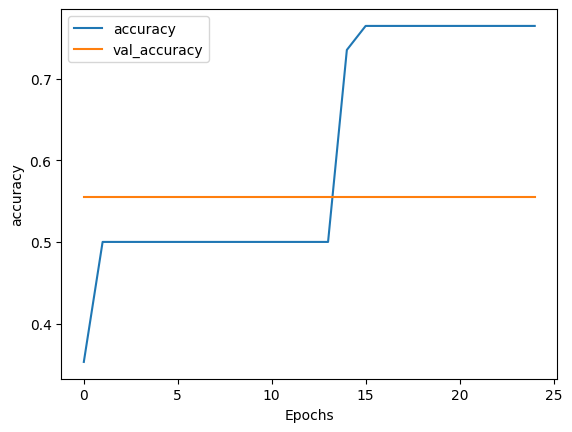

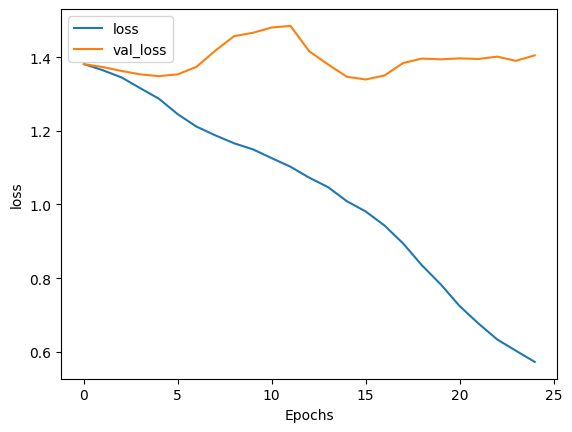

In [177]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [178]:
testing_items_till = 52

In [179]:
prediction_sentences = production_sentences[:testing_items_till]
prediction_sentences[:3]

['kontrast beyin bt kafa kaide kalvarial kemik yapı normal sınır 4 ventrikül bazal sisternalar normal genişlik poster fos oluşum olağan i̇ntrakranial hipo hiperdens sınırlanabi patoloji sapta 3 ventrikül orta hatta normal genişlik lateral ventrikül olağan beyin orta hat yapı yer değiş sapta serebral sulkus olağan nazal septum sol deviye görünüm btye yansı tipik bir akut iskemi bulgu mevcut değil ancak konu klinik kuşku var olgu diffüzyon mrg değer detaylandırılması yarar ol',
 'sol serebellar hemisfer sekel ensefalomalazi saha eski iskemi sekel değişik izle sağ serebellar hemisfer düzey benzer bulgu izle birlikte iki serebellumda atrofi bulgu folyo belirgin mevcut supratentorial kesit değerlendirilmesin 3 lateral ventrikul konveksit sulkus atrofiye sekonder belirgin sağ poster serebral arter sula saha kronik iskemik sekel gliozis saha varlık mevcut periventrikuler lökoriazis alan izle',
 'periventriküler derin beyaz cevher kronik iskemik gliozise bağ dansite kayıp izle bazal sisterna s

In [180]:
# predict a sentence
tokenizer.fit_on_texts(prediction_sentences)
prediction_sequences = tokenizer.texts_to_sequences(prediction_sentences)
prediction_padded = pad_sequences(prediction_sequences, maxlen=max_input_length, padding=padding_type, truncating=trunc_type)
prediction_padded = np.array(prediction_padded)
prediction_padded

array([[233,  20,  80,   9,  32,  28,  15,   8,   2,  29,  23,   1,  24,
         19,   2,   5,  17,  33,  34,   3,  35,  36,  37,  38,  39,   6,
         13,   1,   7,  30,   2,   5,  11,   1,   3,  20,   7,  14,   8,
         21,  31,   6,  16,  12,   3, 113, 234,  43, 235,  46, 236, 237,
        238, 136,  78, 163,  60,  22, 239, 240, 241, 164, 242, 243, 244,
        245, 246,  67, 247, 248,  10],
       [ 43,  51,  62,  97, 165, 123, 150, 163,  97,  89,   4,  18,  51,
         62,  48, 249,  60,   4, 127,  56, 250,  70,  60,  69,  61,  22,
         63,  27,  75,  13,  11, 155, 108,  12,  87,  88,  61,  18,  17,
         16, 251, 252, 123,  58, 120,  97, 166, 123,  76,  22, 156, 145,
         44,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0],
       [ 52, 105,  53,  72,  58, 120, 151,  74,  68,  66,   4,  24, 253,
         16, 254, 255,   5,  70,  45,  71,  18, 256, 257,  58,  77,  97,
        165, 166,  45, 121,  83,  22,  18, 258

In [181]:
predictions = model.predict(prediction_padded)
predictions = [np.argmax(prediction) for prediction in predictions]

1/1 [==============================] - 0s 32ms/step


In [183]:
actual_labels

[1, 3, 3, 0, 0, 1, 1, 1, 1, 1]

In [184]:
predictions

[1, 3, 1, 1, 3, 1, 1, 1, 1, 1]

In [182]:
actual_labels = production_labels[:testing_items_till]
calculate_matching_ratio(actual_labels, predictions)

0.7